In [89]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [90]:
#import ML models

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


In [91]:
from IPython.core.display import HTML
css = open('../Data/style-table.css').read() + open('../Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [92]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


In [93]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('../Data/USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('../Data/USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('../Data/USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('../Data/USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('../Data/USMTO5.csv', index_col = False)

In [94]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv('../Data/SP_500.csv', index_col = False)

In [95]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [96]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [97]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [98]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [99]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [100]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [101]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [102]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [103]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [104]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [105]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)


In [106]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

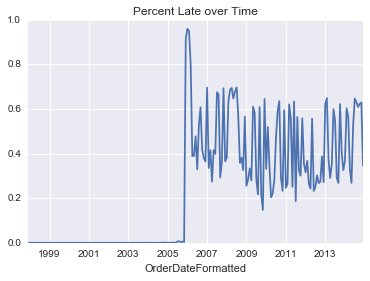

In [107]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [108]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [109]:
USMTO_WHOLE.columns

Index(['OrderID', 'AAID', 'NAICSID', 'CustomerZipCode', 'ShippingCountryID',
       'ShippingZipCode', 'Units', 'TotalSale', 'CreatedBy', 'CreateDate',
       'ChangedBy', 'IsSubmitted', 'TopCategoryName', 'SubCategory',
       'SubCategoryName', 'Description', 'MachineCode', 'EntryMonth',
       'EntryYear', 'Date', 'Close', 'IP', 'OrderDateFormatted',
       'ChangedDateFormatted', 'SubmitDateFormatted', 'OrderDateEOM',
       'DaysLate', 'IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill'],
      dtype='object')

In [110]:
USMTO_WHOLE.describe()

,AAID,NAICSID,Units,TotalSale,IsSubmitted,SubCategory,MachineCode,EntryMonth,EntryYear,Close,IP,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill
count,392068.000000,392068.000000,392068.000000,3.920680e+05,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000,392068.000000
mean,101567.163523,451.643654,0.969559,1.511589e+05,0.999612,26.011322,3568.717931,6.866054,2010.319011,1424.766320,100.536678,14.907945,0.440000,0.303307,0.213754,0.031885
std,5267.014327,280.468735,0.234727,2.890960e+05,0.019686,9.751844,384.827128,3.410505,2.604354,282.721568,4.419017,92.569530,0.496388,0.459687,0.409955,0.175694
min,123.000000,1.000000,-1.000000,-9.861252e+06,0.000000,1.000000,3541.205000,1.000000,2006.000000,735.090027,87.412500,-39.000000,0.000000,0.000000,0.000000,0.000000
25%,100132.000000,209.000000,1.000000,4.598594e+04,1.000000,23.000000,3541.540000,4.000000,2008.000000,1267.380005,97.747400,-4.000000,0.000000,0.000000,0.000000,0.000000
50%,100333.000000,248.000000,1.000000,8.190807e+04,1.000000,23.000000,3541.704000,7.000000,2011.000000,1397.910034,101.601600,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100525.000000,749.000000,1.000000,1.650000e+05,1.000000,36.000000,3541.708000,10.000000,2013.000000,1549.380005,104.172000,7.000000,1.000000,1.000000,0.000000,0.000000
max,123556.000000,924.000000,1.000000,4.475133e+07,1.000000,44.000000,9999.999000,12.000000,2014.000000,2067.560059,106.686800,3190.000000,1.000000,1.000000,1.000000,1.000000


In [111]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


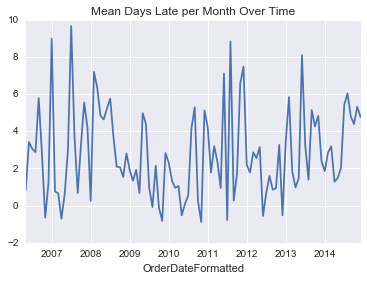

In [112]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

In [113]:
#possible causes of change in oscillation
#box and whisker plots - how distribution changed over time
#change of median, edge, etc?
#potential companies that may have joined around 2005


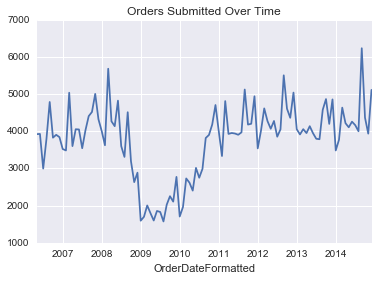

In [114]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

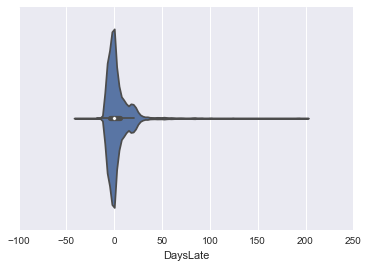

In [115]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [116]:
#Creates table by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.head()

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01,522.0,1,1,1,1,1468.359985,105.7256,13,18461.538462,240000.0
1,123,2010-10-01,673.0,1,1,1,1,1183.260010,95.6362,2,100000.000000,200000.0
2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,7,131438.714286,920071.0
3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2,153945.500000,307891.0
4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,11,57971.090909,637682.0


In [117]:
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.head()

,level_0,index,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units_x,TotalSaleAvg,Units_y,TotalSale
0,0,0,123,2007-12-01,522.0,1,1,1,1,1468.359985,105.7256,13,240000.0,13,240000.0
1,1,1,123,2010-10-01,673.0,1,1,1,1,1183.260010,95.6362,2,200000.0,2,200000.0
2,2,2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,7,920071.0,7,920071.0
3,3,3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2,307891.0,2,307891.0
4,4,4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,11,637682.0,11,637682.0


In [118]:
ALL_AAIDS = AAID_BY_MONTH.AAID.unique()

In [119]:
#result = pd.DataFrame({'A' : []})

#for a in ALL_AAIDS:
    #tempdf = AAID_BY_MONTH[AAID_BY_MONTH.AAID == a]
    #tempdf['UnitsLast'] = tempdf.Units.shift(1)
    #tempdf['IsCallLast'] = tempdf.IsCall.shift(1)
    #tempdf['TotalSaleAvgLast'] = tempdf.TotalSaleAvg.shift(1)
    #tempdf['TotalSaleLastThree'] = (tempdf.TotalSale.shift(1) +tempdf.TotalSale.shift(2)  + tempdf.TotalSale.shift(3))/3
    #tempdf['DaysLastLastThree'] = (tempdf.DaysLate.shift(1) +tempdf.DaysLate.shift(2)  + tempdf.DaysLate.shift(3))/3
    #tempdf['DaysLastLast'] = tempdf.DaysLate.shift(1)
    #tempdf.fillna(value = 0)
    #result.append(tempdf)

In [149]:
#imports tables to work on, created from CreateAAIDByMonth

#USMTO_WHOLE = pd.DataFrame.from_csv('../Data/USMTO_WHOLE.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/result.csv', index_col = False)
#AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'])
#AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'])
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)
#AAID_BY_MONTH = pd.DataFrame.from_csv('../Data/AAID_BY_MONTH.csv', index_col = False)


In [188]:
#temporary fill in for adding in feature engineered vars until python script is written

#AAID_BY_MONTH_NO_BACKFILL.to_csv('../Data/AAIDByMonth',sep = ',')
#AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/AAID By Month Edited.csv', index_col = False)
#AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['DaysLateLastThree'])
#AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'] = pd.to_numeric(AAID_BY_MONTH_NO_BACKFILL['TotalSaleLastThree'])
#AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)


In [189]:
AAID_BY_MONTH_NO_BACKFILL.columns

Index(['Unnamed: 0', 'AAID', 'OrderDateFormatted', 'DaysLate', 'IsEmailOne',
       'IsEmailTwo', 'IsCall', 'IsBackfill', 'Close', 'IP', 'Units',
       'TotalSaleAvg', 'TotalSale', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLastLastThree',
       'DaysLateLast'],
      dtype='object')

In [152]:
#exports days late by aaid for further analysis

b = AAID_BY_MONTH_NO_BACKFILL.groupby(['AAID'])['DaysLate'].mean()
c = pd.DataFrame(b)
c.to_csv('../Data/DaysLateByAAID',sep = ',')

In [153]:
#create column "Three MMA Late" - which models the average of the past three month's lateness for each company

#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_Late'] = AAID_BY_MONTH_NO_BACKFILL.DaysLate.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_Late'].mean().plot(kind = 'line')


In [154]:
#AAID_BY_MONTH_NO_BACKFILL['Three_MMA_SalesTrend'] = AAID_BY_MONTH_NO_BACKFILL.TotalSale.ewm(span=3).mean()
#AAID_BY_MONTH_NO_BACKFILL.groupby(['OrderDateFormatted'])['Three_MMA_SalesTrend'].sum().plot(kind = 'line')

In [155]:
AAID_BY_MONTH_NO_BACKFILL.columns

Index(['Unnamed: 0', 'AAID', 'OrderDateFormatted', 'DaysLate', 'IsEmailOne',
       'IsEmailTwo', 'IsCall', 'IsBackfill', 'Close', 'IP', 'Units',
       'TotalSaleAvg', 'TotalSale', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLastLastThree',
       'DaysLateLast'],
      dtype='object')

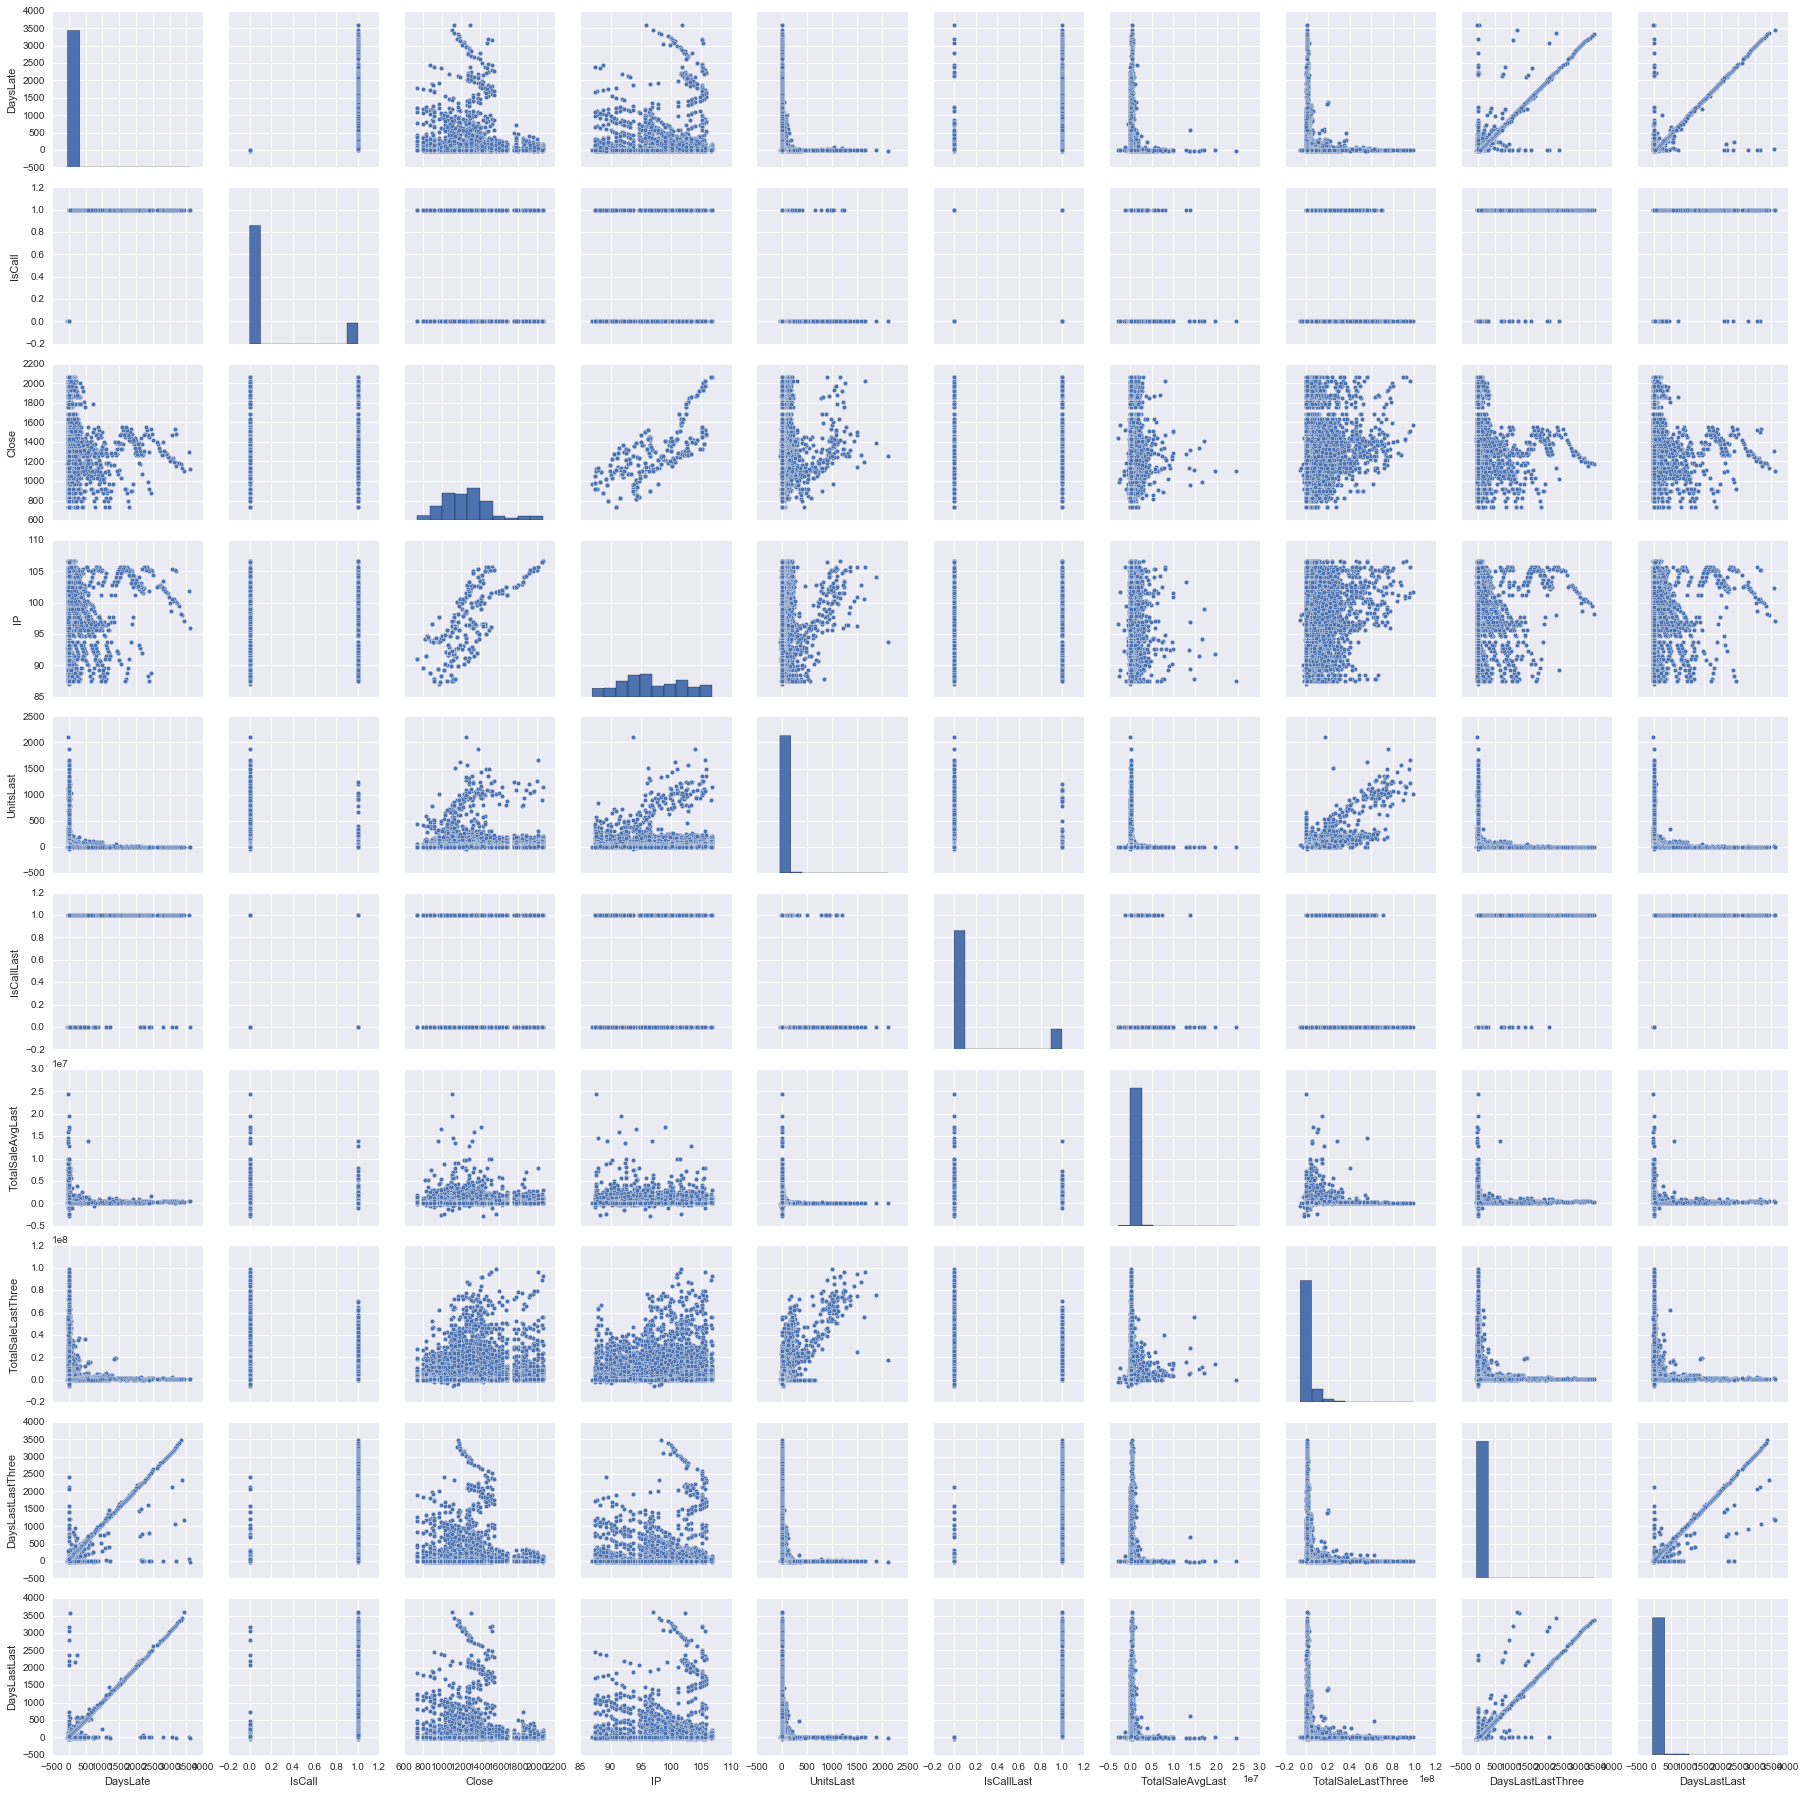

In [137]:
#scatter matrix identifying key features - target excluded
PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0',axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)

sns.pairplot(PAIRPLOT2)

In [157]:
AAID_BY_MONTH_NO_BACKFILL.columns

Index(['Unnamed: 0', 'AAID', 'OrderDateFormatted', 'DaysLate', 'IsEmailOne',
       'IsEmailTwo', 'IsCall', 'IsBackfill', 'Close', 'IP', 'Units',
       'TotalSaleAvg', 'TotalSale', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLastLastThree',
       'DaysLateLast'],
      dtype='object')

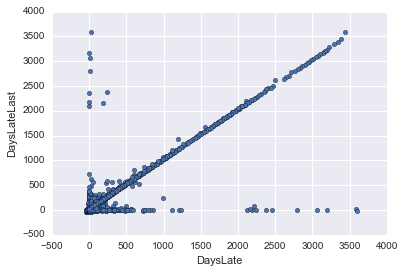

In [156]:
#DaysLate Last vs Days Late (suspicious line - business reason for this, not data error)

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

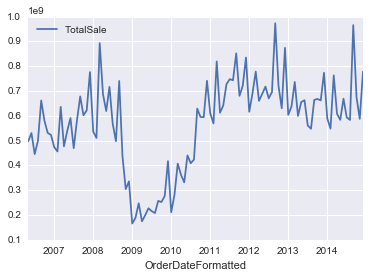

In [140]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

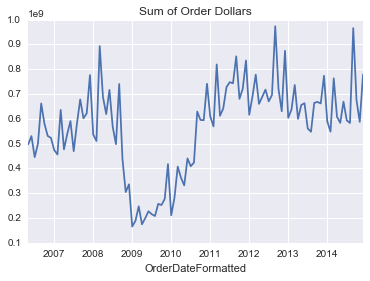

In [141]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Sum of Order Dollars')

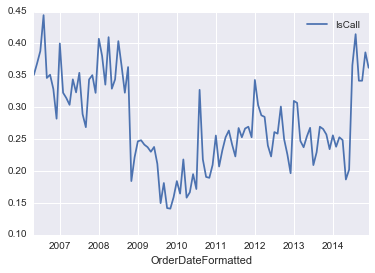

In [142]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

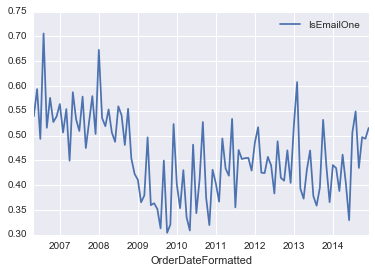

In [143]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

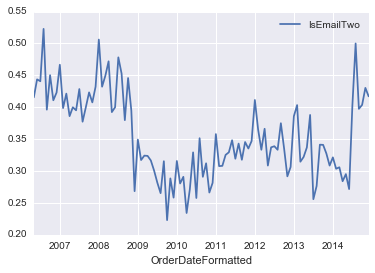

In [144]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

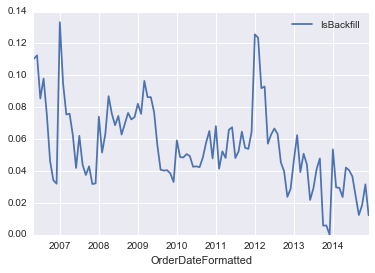

In [145]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [148]:
PAIRPLOT2.columns

Index(['Unnamed: 0', 'IsCall', 'Close', 'IP', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLastLastThree',
       'DaysLastLast'],
      dtype='object')

In [164]:
#prep for correlation matrix - target included. also the dataframe for machine learning algorithms

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLateLast', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0', axis = 1)



corr2 = PAIRPLOT2.corr(method = 'pearson')

In [165]:
PAIRPLOT2.columns

Index(['IsCall', 'Close', 'IP', 'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast',
       'TotalSaleLastThree', 'DaysLastLastThree'],
      dtype='object')

In [166]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    30225
1     5217
dtype: int64

In [167]:
#Skew of Attributes

PAIRPLOT2.skew()

IsCall                 1.991608
Close                  0.821540
IP                     0.077500
UnitsLast             13.587794
IsCallLast             2.027617
TotalSaleAvgLast      17.297064
TotalSaleLastThree     6.456551
DaysLastLastThree     13.535677
dtype: float64

In [168]:
PAIRPLOT2.corr()

,IsCall,Close,IP,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLastLastThree
IsCall,1.000000,0.194020,0.307667,-0.006363,0.615430,0.034756,0.027401,0.289178
Close,0.194020,1.000000,0.701660,0.053513,0.189493,0.035321,0.108959,0.015919
IP,0.307667,0.701660,1.000000,0.061784,0.298237,0.028643,0.121453,0.088856
UnitsLast,-0.006363,0.053513,0.061784,1.000000,-0.003851,-0.042235,0.744296,-0.013005
IsCallLast,0.615430,0.189493,0.298237,-0.003851,1.000000,0.033838,0.030377,0.311263
TotalSaleAvgLast,0.034756,0.035321,0.028643,-0.042235,0.033838,1.000000,0.114848,0.018749
TotalSaleLastThree,0.027401,0.108959,0.121453,0.744296,0.030377,0.114848,1.000000,-0.010743
DaysLastLastThree,0.289178,0.015919,0.088856,-0.013005,0.311263,0.018749,-0.010743,1.000000


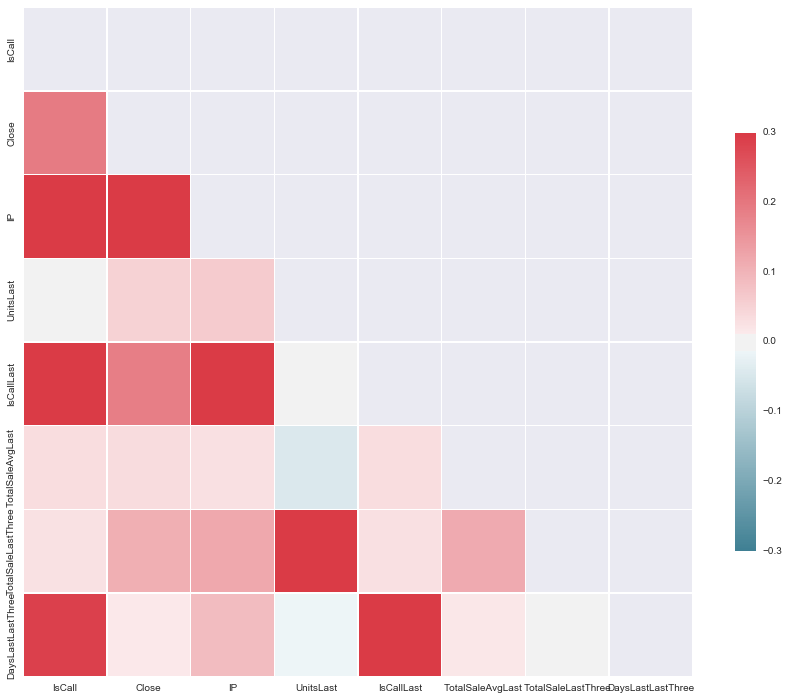

In [169]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


In [170]:
#rescales all data to be between 0 and 1 and readies it for further processing - in progress

import scipy

from sklearn.preprocessing import MinMaxScaler

array = PAIRPLOT2.values
# separate array into input and output components
X = array[:,1:14]
Y = array[:,0]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)

#rescaledX3 = rescaledX.reshape((-1,8))

#rescaledX3 = pd.DataFrame({'IsCall':rescaledX[:,0],'Close':rescaledX[:,1],'Three_MMA_Late':rescaledX[:,2],'Three_MMA_SalesTrend':rescaledX[:,3],'DaysLateLastThree':rescaledX[:,4],'TotalSaleLastThree':rescaledX[:,5],'DaysLateLast':rescaledX[:,6],'UnitsLast':rescaledX[:,7],'IsCallLast':rescaledX[:,8]})
#sns.boxplot(data = rescaledX3, orient = 'h', fliersize = '.5')

In [171]:
PAIRPLOT2.describe()

,IsCall,Close,IP,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLastLastThree
count,35442.000000,35442.000000,35442.000000,35442.00000,35442.000000,3.544200e+04,3.544200e+04,35442.000000
mean,0.147198,1272.547978,96.863928,19.13453,0.144038,2.137761e+05,2.769264e+06,13.744390
std,0.354308,258.449236,5.070090,68.27546,0.351133,4.799783e+05,6.243890e+06,143.248970
min,0.000000,735.090027,86.945400,-34.00000,0.000000,-2.802056e+06,-5.691504e+06,-36.333333
25%,0.000000,1104.489990,93.111400,3.00000,0.000000,5.952522e+04,3.846247e+05,-4.000000
50%,0.000000,1253.300049,96.276900,7.00000,0.000000,1.206912e+05,1.056407e+06,0.000000
75%,0.000000,1400.630005,101.244300,16.00000,0.000000,2.334610e+05,2.550313e+06,1.000000
max,1.000000,2067.560059,106.686800,2110.00000,1.000000,2.440000e+07,9.903093e+07,3470.666667


In [172]:
#rescaledX3.describe()

In [173]:
#relationship between last month's days late and this month's call

#rescaledX3.plot.scatter('DaysLateLast','IsCall')

In [174]:
#columns which correspond to feature selection output

PAIRPLOT2.columns

Index(['IsCall', 'Close', 'IP', 'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast',
       'TotalSaleLastThree', 'DaysLastLastThree'],
      dtype='object')

In [175]:
# Feature Importance with Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.06785894  0.08887349  0.09413612  0.35874849  0.11116695  0.10975031
  0.1694657 ]


In [176]:
# Feature Extraction with RFE 

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

Num Features:  4
Selected Features:  [ True  True False  True False False  True]
Feature Ranking:  [1 1 2 1 3 4 1]


In [177]:
#Feature Extraction with PCA - in progress

from sklearn.decomposition import PCA
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
pca = PCA(n_components=4)
fit = pca.fit(X)
# summarize components
print("Explained Variance: ", fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance:  [  9.94203397e-01   5.79660085e-03   1.68274489e-09   5.22775030e-10]
[[ -4.51055130e-06  -9.86249626e-08  -8.13742474e-06  -1.70937201e-09
   -8.88001323e-03  -9.99960572e-01   2.46135359e-07]
 [ -1.24053655e-05  -1.56421044e-07   1.84830304e-05  -2.24848433e-08
   -9.99960572e-01   8.88001313e-03  -6.04584459e-06]
 [ -9.99791389e-01  -1.36797859e-02   6.79837379e-03  -2.58396001e-04
    1.26515726e-05   4.34012716e-06  -1.35556931e-02]
 [  1.35993746e-02  -2.58873428e-03   9.62878261e-04  -7.51820979e-04
    5.89174436e-06  -3.67364268e-07  -9.99903427e-01]]


In [178]:
#we end up using all features

In [179]:
#test different types of models

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.33
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 5
num_instances = len(X_train)
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) - causes code to hang
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)


('LR', 0.85702906539880974, 0.009976703429585879)
('LDA', 0.90402603983110019, 0.0048555650231962497)
('KNN', 0.83673063137945936, 0.005981274247157854)
('CART', 0.88040120136095124, 0.0041962900407779141)
('NB', 0.85820790637364086, 0.0049511345362431352)


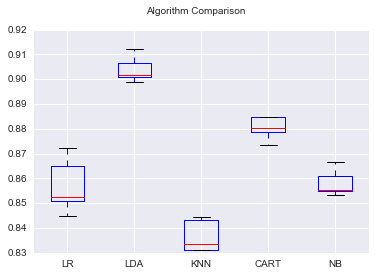

In [180]:
#distribution of models, accuracy and std dev

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [181]:
PAIRPLOT2.head()

,IsCall,Close,IP,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLastLastThree
0,1,1468.359985,105.7256,0.0,0.0,0.000000,0.0,0.0
1,1,1183.260010,95.6362,13.0,1.0,18461.538462,0.0,0.0
2,0,1120.670044,87.5421,0.0,0.0,0.000000,0.0,0.0
3,0,1328.719971,92.5769,44.0,0.0,187122.227273,0.0,0.0
4,0,1320.410034,92.9517,37.0,0.0,171106.270270,0.0,0.0


In [182]:
a = pd.DataFrame({'a':X[:,0],'b':X[:,1],'c':X[:,2],'d':X[:,3],'e':X[:,4],'f':X[:,5],'g':X[:,6]}).head()

print (a.columns)
print (PAIRPLOT2.columns)

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g'], dtype='object')
Index(['IsCall', 'Close', 'IP', 'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast',
       'TotalSaleLastThree', 'DaysLastLastThree'],
      dtype='object')


In [183]:
>>> from sklearn import tree
>>>
>>> clf = tree.DecisionTreeClassifier()
>>> clf = clf.fit(X_train, Y_train)
>>> tree.export_graphviz(clf,
...     out_file='usmto3.dot',feature_names = a.columns)   

In [184]:
>>> from sklearn.externals.six import StringIO
>>> with open("usmto3.dot", 'w') as f:
...     f = tree.export_graphviz(clf, out_file=f)

>>> import os
>>> os.unlink('usmto3.dot')

In [185]:
#classification report with best model (Decision Trees)

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.93      0.93      0.93      9983
        1.0       0.59      0.60      0.60      1713

avg / total       0.88      0.88      0.88     11696



In [186]:
# Cross Validation Classification LogLoss (smaller logloss better with 0 as perfect logloss)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'log_loss'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("Logloss: ", results.mean(), "      Std Dev: ", results.std()*100.0)

Logloss:  -0.378956800106       Std Dev:  20.3763631974


In [187]:
# Cross Validation Classification with Area Under the Curve (Between 0.5 and 1 indicates good model)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'roc_auc'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: ", results.mean(), "      Std Dev: ", results.std()*100.0)


AUC:  0.885901930287       Std Dev:  3.60293780134


In [ ]:
********BREAK**********

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


In [ ]:

# Import some data to play with
array = PAIRPLOT2.values
X = array[:,1:14]
y = array[:,0]

# Binarize the output
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


In [ ]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#APPENDIX AS FOLLOWS: (works in progress)

In [ ]:
#cols to create:

#3 MMA company sales
#3 MMA lateness
# s&p 500 
machine tool mix
#prior month late days
# scatter matrix



In [ ]:
#attempts to map which AAIDs submitted over what dates

AAIDs = pd.DataFrame.from_csv('AAIDs.csv', index_col = False)

In [ ]:
AAIDs = AAIDs.fillna('')

In [ ]:
AAIDs

In [ ]:
#plots distribution who received a first email, over all time

USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailOne'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsEmailTwo'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsCall'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE.groupby('OrderDateFormatted')['IsBackfill'].mean().plot(kind = 'hist',bins = 10)

In [ ]:
USMTO_WHOLE